Notebook for evaluating a cross-validated 3D U-Net with residual connections and an attention mechanism. 

Import depenencies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


Initialise constants. Note that the seed value should be the same one used in cross-validation. 

In [2]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Load the data. 

In [3]:
# Paths on local machine
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset_64.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset_64.npy"

mris = np.load(mris_path)
masks = np.load(masks_path)

Normalise the data. 

In [4]:
def standardize_3d_image(img):
    """
    Standardize a 3D image using Z-score normalization.

    Parameters:
    - img: 3D numpy array representing the MRI image.

    Returns:
    - standardized_img: 3D numpy array representing the standardized MRI image.
    """
    mean = np.mean(img)
    std = np.std(img)
    standardized_img = (img - mean) / std
    return standardized_img

In [5]:
for i in range(mris.shape[0]):
    mris[i] = standardize_3d_image(mris[i])

Split the dataset using the same seed value as in the 5-fold cross-validation to avoid data leakage. 

In [6]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

Load a model and train with the whole dataset. 

In [26]:
model = tf.keras.models.load_model(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\fold_4",
    custom_objects={"f1-score": sm.metrics.FScore(), "dice_loss_plus_binary_crossentropy":sm.losses.DiceLoss() + sm.losses.BinaryCELoss()},
)

A function for evaluating the segmentation results using Dice Score. 

In [9]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score

A function for saving the test results into a Pandas dataframe. 

In [17]:
def build_dfs(test_ids, dice_scores):
    data = {
        "Patient Indices": test_ids,
        "Dice": dice_scores
    }
    # Create DataFrame
    df = pd.DataFrame(data)
    # Calculate the average and standard deviation of dice_scores
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)
    
    # add a new row with average and standard deviation
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Avg."], "Dice": [f"{avg_dice:.2f}"]})], ignore_index=True)
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Std."], "Dice": [f"{std_dice:.2f}"]})], ignore_index=True)

    
    return df

Evaluate the model first on the test set before training with the whole training set. 

In [27]:
model_dsc_before = [] # list for containing an individual test folds dice scores

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    model_dsc_before.append(dice_score)
print(np.mean(model_dsc_before))

1/1 [==============================] - 0s 19ms/step
0.8399217324312342


Set callback for the training. 

In [28]:
cb = tf.keras.callbacks.EarlyStopping(
monitor="f1-score", mode="max", patience=5, restore_best_weights=True
)

In [29]:
model_history = model.fit(X_train, Y_train, epochs=50, batch_size=2, callbacks=[cb])

Epoch 1/50
97/97 [==============================] - 17s 155ms/step - loss: 0.0845 - f1-score: 0.9160
Epoch 2/50
97/97 [==============================] - 14s 146ms/step - loss: 0.0751 - f1-score: 0.9254
Epoch 3/50
97/97 [==============================] - 15s 158ms/step - loss: 0.0678 - f1-score: 0.9324
Epoch 4/50
97/97 [==============================] - 16s 160ms/step - loss: 0.0674 - f1-score: 0.9324
Epoch 5/50
97/97 [==============================] - 16s 168ms/step - loss: 0.0645 - f1-score: 0.9362
Epoch 6/50
97/97 [==============================] - 16s 169ms/step - loss: 0.0715 - f1-score: 0.9293
Epoch 7/50
97/97 [==============================] - 16s 162ms/step - loss: 0.0674 - f1-score: 0.9333
Epoch 8/50
97/97 [==============================] - 15s 154ms/step - loss: 0.0685 - f1-score: 0.9320
Epoch 9/50
97/97 [==============================] - 15s 150ms/step - loss: 0.0590 - f1-score: 0.9414
Epoch 10/50
97/97 [==============================] - 16s 164ms/step - loss: 0.0626 - f1-sco

Plot the training Dice Score. 

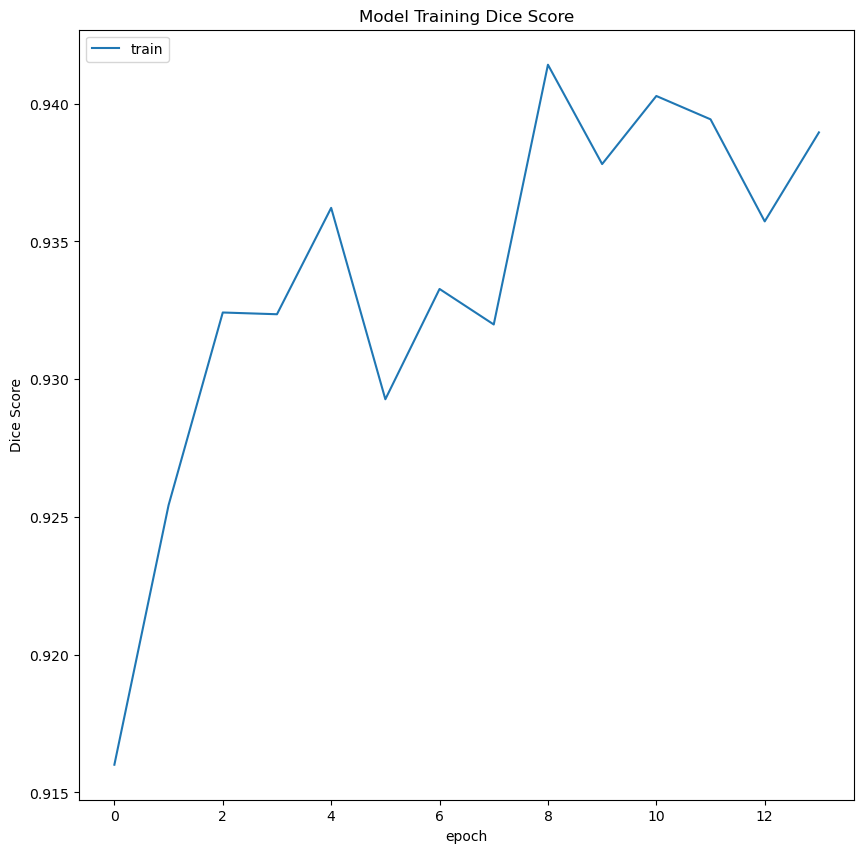

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(model_history.history["f1-score"])
plt.title("Model Training Dice Score")
plt.ylabel("Dice Score")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

Evaluate the model on the test set after training with the whole training set. 

In [31]:
model_dice_after = [] # list for containing an individual test folds dice scores

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = avg_model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    model_dice_after.append(dice_score)
print(np.mean(model_dice_after))

1/1 [==============================] - 0s 20ms/step
0.841129762951041


Save the evaluation results to a Pandas dataframe. 

In [32]:
model_df = build_dfs(test_indices, model_dice_after)

In [33]:
model_df

,Patient Indices,Dice
0,24,0.598726
1,6,0.875912
2,152,0.935065
3,209,0.971292
4,237,0.951807
5,199,0.974359
6,190,0.972112
7,150,0.952756
8,9,0.933092
9,113,0.912281


Create a function to plot patientwise dice scores from a dataframe.  

In [34]:
def plotDice(dataframe):

    plt.figure(figsize=(10, 20))  # Increased height
    spacing = 1.5  # Adjust this to increase/decrease spacing
    y_positions = np.arange(len(dataframe)-2) * spacing
    plt.barh(y_positions, dataframe["Dice"].iloc[:-2], color="blue", edgecolor="black") # leave out the avg. and std. lines of the df
    plt.ylabel("Index")
    plt.xlabel("Dice Score")
    plt.title("Dice Scores per Index")
    plt.yticks(y_positions, dataframe["Patient Indices"].iloc[:-2])
    
    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

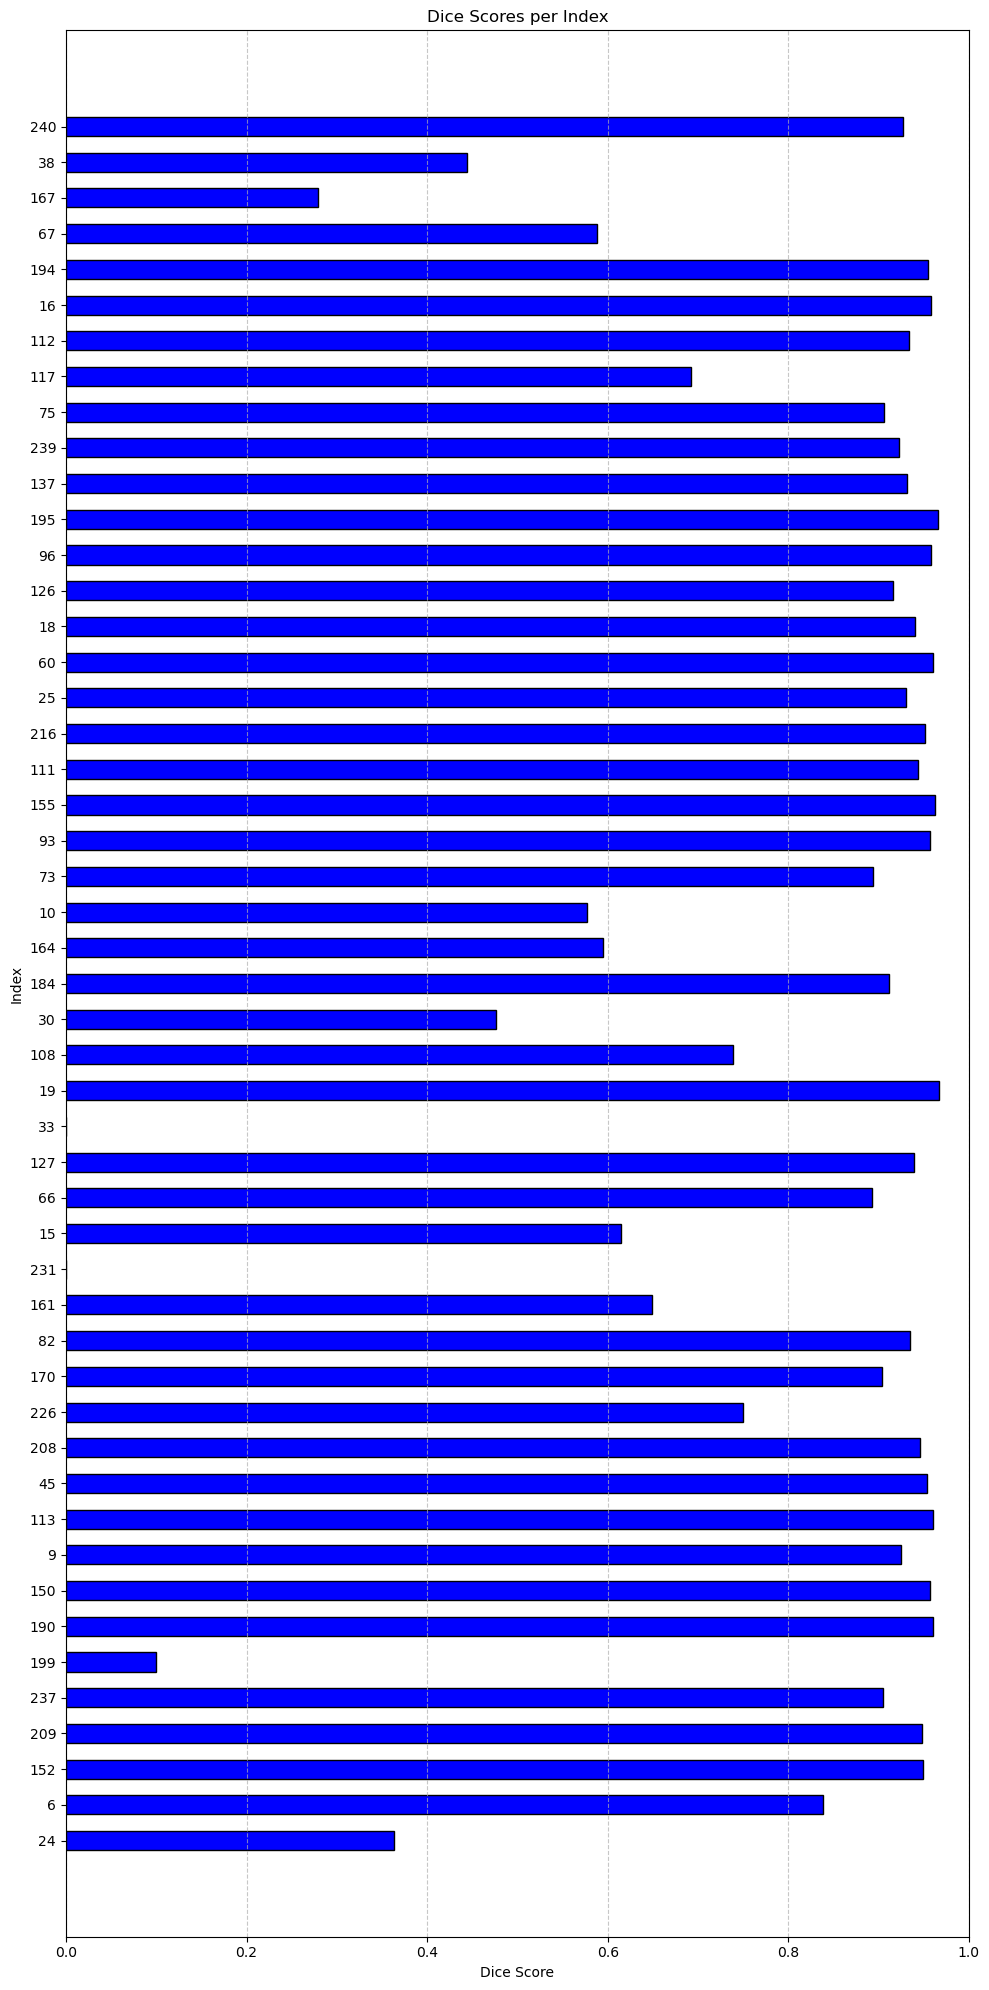

In [21]:
plotDice(model_df)

In [50]:
def plot_test_image_with_contours(index, X_test, Y_test):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in the same figure.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(X_test[index, ...], axis=0))
    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ] # Get the slices where annotation

    num_slices = len(slice_indices)
    fig = plt.figure(figsize=(5, 5 * num_slices))
    #Fix this supertitle
    #fig.suptitle(f'Example images of patient index {avg_model_df["Patient Indices"].iloc[index]} with Dice score of {avg_model_df["Dice"].iloc[index]} ', fontsize=20, fontweight='bold')
    for i, idx in enumerate(slice_indices):
        plt.subplot(num_slices, 1, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="g", linewidths=0.5)

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0, :, :, idx, 0], colors="r", linewidths=0.5
        )

        plt.title(f"Slice {idx} with Annotated (Green) and Predicted (Red) Contours")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 21ms/step


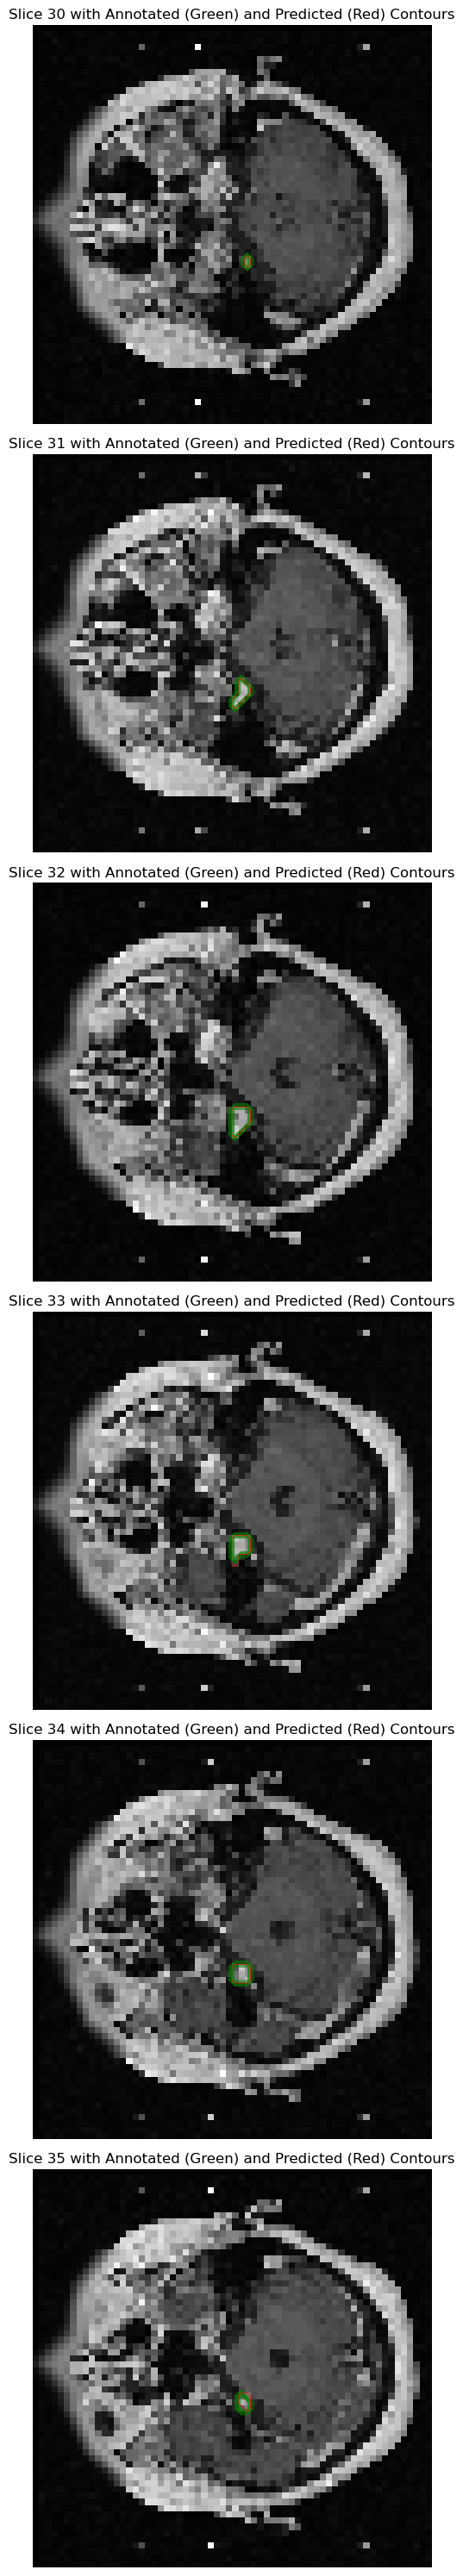

In [51]:
plot_test_image_with_contours(21, X_test, Y_test)

In [37]:
with pd.ExcelWriter(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\kfold_cv_models\avg_model_df.xlsx"
) as writer:
    model_df.to_excel(writer, sheet_name="Avg model scores")